In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [243]:
#μ=∑i=mN(Ni)pi(1−p)N−i

#96.67

In [244]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table 

In [245]:
data = pd.read_csv('credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [136]:
data.dtypes


SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

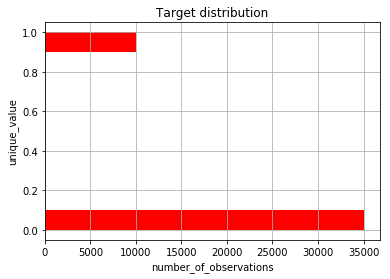

In [137]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

In [246]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [247]:
table = impute_nan_with_median(data)

In [140]:
table.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [248]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [249]:
data['MonthlyIncome'].mean()

6205.560459800723

In [250]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the loyal and former customers to split the dataset
good_customers = data[data['SeriousDlqin2yrs'] == 0]['MonthlyIncome'].values
bad_customers = data[data['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].values

# Set the seed for reproducibility of the results
np.random.seed(17)

# Generate the samples using bootstrapping and calculate the mean for each of them
good_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(good_customers, 1000)]
bad_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bad_customers, 1000)]

# Print the resulting interval estimates
print("Monthly Income of good customers: mean interval", stat_intervals(good_mean_scores, 0.10))
print("Monthly Income of bad customers: mean interval", stat_intervals(bad_mean_scores, 0.10))

good_interval = stat_intervals(good_mean_scores, 0.10)
bad_interval = stat_intervals(bad_mean_scores, 0.10)

Monthly Income of good customers: mean interval [6295.93237577 6505.35467934]
Monthly Income of bad customers: mean interval [5471.64826451 5643.93562737]


In [251]:
good_interval[0] - bad_interval[1]

651.9967484053386

In [252]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [253]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')


In [254]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [255]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)


In [256]:
clf = GridSearchCV(dt, tree_params, cv=skf, scoring='roc_auc',
                      verbose=True, n_jobs=8)

clf.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [235]:
clf.best_score_, clf.best_params_

(0.8203023476209635, {'max_depth': 7, 'max_features': 6})

In [237]:
# best_score_std/best_score > 1%
#clf.cv_results_
( 0.00484198 / 0.8203023476209635) * 100

0.5902677243387983

In [151]:
clf.cv_results_ 

/Users/monicasieklucki/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/monicasieklucki/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/monicasieklucki/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/

{'mean_fit_time': array([0.17756095, 0.1280417 , 0.17358899, 0.2110146 , 0.18643765,
        0.15538964, 0.20138044, 0.25512681, 0.23674717, 0.25846276,
        0.24041986, 0.28455248, 0.22972927, 0.26494389, 0.28917179,
        0.30933585, 0.2392221 , 0.2789434 , 0.31265769, 0.33360348]),
 'std_fit_time': array([0.01624143, 0.03534016, 0.05856355, 0.01204463, 0.00473107,
        0.05677769, 0.02430024, 0.01271839, 0.02515171, 0.01744783,
        0.02246042, 0.01322734, 0.01396475, 0.00736535, 0.01020293,
        0.00881039, 0.01130051, 0.00648899, 0.0071236 , 0.04827186]),
 'mean_score_time': array([0.03673921, 0.01147232, 0.0074131 , 0.0055676 , 0.00555797,
        0.00487709, 0.01339312, 0.01632938, 0.01056166, 0.01154246,
        0.01131101, 0.00539942, 0.01087413, 0.0081697 , 0.00740175,
        0.01563835, 0.01175857, 0.009096  , 0.01235642, 0.00787134]),
 'std_score_time': array([0.02017059, 0.00578528, 0.00401679, 0.00048125, 0.00026584,
        0.00074835, 0.00394247, 0.012675

In [152]:
clf.cv_results_['std_train_score'].std() * 100

/Users/monicasieklucki/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.06536016055195612

In [318]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    
    def fit(self, X, y):            
        # Your code is here
        self.feat_ids_by_tree = X.columns.values
        for i in range(self.n_estimators):
            bootstrap_samples = np.random.choice(np.asarray(self.feat_ids_by_tree), size=10, replace=True)

            self.random_state = self.random_state + i
            dt = DecisionTreeClassifier(random_state=self.random_state, class_weight='balanced',
                                    max_depth = self.max_depth, max_features = self.max_features )
            dt.classes_ = bootstrap_samples
            dt.n_features_ = 10
            self.trees.append(dt)
        return self

    
    def predict_proba(self, X):
        average = 0.00
        # Your code is here
        for dt in self.trees:
            tree_params = {'max_depth': [dt.max_depth],
               'max_features': [dt.max_features] }

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=dt.random_state)
            clf = GridSearchCV(dt, tree_params, cv=skf, scoring='roc_auc')
            clf.fit(X, y)
            clf.best_score_
            average += clf.best_score_

        return ( average / len(self.trees) )

In [326]:
clf = RandomForestClassifierCustom(n_estimators=10, max_depth=10, max_features=7, 
                 random_state=17)

clf.fit(X, y)


RandomForestClassifierCustom(max_depth=10, max_features=7, n_estimators=10,
               random_state=62)

In [327]:
average = clf.predict_proba(X)


0.7991791807976668
0.8013176300099001
0.8003111805077433
0.8019102276538148
0.8003171460541618
0.8029463838201809
0.7978426129823631
0.7997274521904565
0.8002178945910978
0.7994713003048994


In [321]:
print(average)

0.8003241008912285


In [187]:
rf = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=10, 
                 random_state=17)


#max_depth_values = [5, 6, 7, 8, 9]
#max_features_values = [4, 5, 6, 7]
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

clf = GridSearchCV(rf, tree_params, cv=skf, scoring='roc_auc')

clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15), 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [188]:
clf.best_score_, clf.best_params_

(0.832868063141437, {'max_depth': 8, 'max_features': 4})

In [200]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)


clf = GridSearchCV(logit_pipe, logit_pipe_params, cv=skf, scoring='roc_auc')
clf.fit(X, y)
clf.best_score_, clf.best_params_

(0.7878626757307206, {'logit__C': 100000.0})

In [329]:
# Download data
df = pd.read_csv("movie_reviews_train.csv", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [222]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(random_state=17))])

#print(classifier.get_params().keys())

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

#param_grid = {'clf__C': [0.1, 1, 10, 100] }
param_grid = { 'clf__C' : np.logspace(0.1, 1, 10, 100) }
clf = GridSearchCV(classifier, param_grid, cv=skf, scoring='roc_auc')
clf.fit(X_text, y_text)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': array([ 1.25893,  1.58489,  1.99526,  2.51189,  3.16228,  3.98107,
        5.01187,  6.30957,  7.94328, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [223]:
clf.best_score_, clf.best_params_

(0.8625564378667757, {'clf__C': 1.2589254117941673})

In [331]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]




In [ ]:
tree_params = {'clf__max_depth': max_depth,
               'clf__max_features': max_features,
               'clf__min_samples_leaf' : min_samples_leaf }

clf = GridSearchCV(classifier, tree_params, cv=skf, scoring='roc_auc', verbose=True, n_jobs=-1)
clf = clf.fit(X_text, y_text)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
clf.best_score_, clf.best_params_